### SEIR simple 2

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [3]:
class SEIRModel:
    def __init__(self, N, I0=0, E0=0, R0=0):
        self.N = N
        self.I0 = I0
        self.E0 = E0
        self.R0 = R0
        self.S0 = N - E0 - I0 - R0
        self.y0 = self.S0, self.E0, self.I0, self.R0
        self.results = None

    def _seir_equations(self, y, t, beta, sigma, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / self.N
        dEdt = beta * S * I / self.N - sigma * E
        dIdt = sigma * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    def integrate(self, beta, sigma, gamma, days=365):
        t = np.linspace(0, days, days)
        ret = odeint(self._seir_equations, self.y0, t, args=(beta, sigma, gamma))
        self.results = {'S': ret[:, 0], 'E': ret[:, 1], 'I': ret[:, 2], 'R': ret[:, 3], 't': t}
        return self.results

    def plot(self):
        if self.results is None:
            raise ValueError("Please integrate the model first using the 'integrate' method.")
        
        t, S, E, I, R = self.results['t'], self.results['S'], self.results['E'], self.results['I'], self.results['R']
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.5, lw=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time /days')
        ax.set_ylabel('Number')
        ax.set_ylim(0, self.N+100)
        ax.legend()
        plt.title("SEIR Model")
        plt.show()


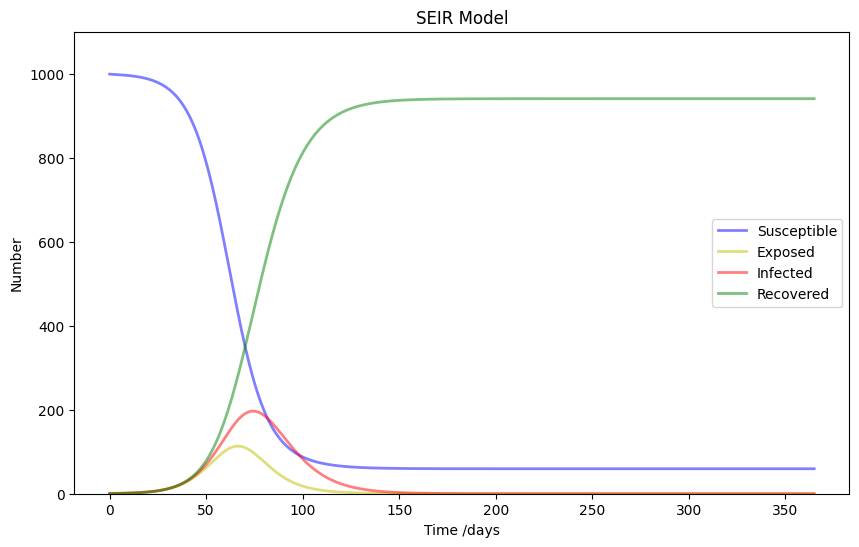

In [4]:
# Testing the SEIRModel class
model_A = SEIRModel(N=1000, I0=1)
model_A.integrate(beta=0.3, sigma=1./5., gamma=1./10.)
model_A.plot()

In [5]:
class TransportBehavior:
    def __init__(self, model_from, model_to):
        self.model_from = model_from  # Source population
        self.model_to = model_to      # Destination population
        self.stay_rate = 0            # Fraction of individuals who decide to stay in the new population after moving

    def set_transport_rates(self, rate_S, rate_E, rate_I, rate_R):
        self.rate_S = rate_S
        self.rate_E = rate_E
        self.rate_I = rate_I
        self.rate_R = rate_R

    def set_stay_rate(self, stay_rate):
        """Set the fraction of individuals who decide to stay in the new population after moving."""
        self.stay_rate = stay_rate

    def apply_transport(self, day):
        """Apply the transport behavior on a particular day."""
        if self.model_from.results is None or self.model_to.results is None:
            raise ValueError("Please integrate the models first using the 'integrate' method of SEIRModel.")
        
        # Calculate the number of individuals moving from source to destination
        delta_S = self.rate_S * self.model_from.results['S'][day]
        delta_E = self.rate_E * self.model_from.results['E'][day]
        delta_I = self.rate_I * self.model_from.results['I'][day]
        delta_R = self.rate_R * self.model_from.results['R'][day]

        # Apply the changes to both populations
        self.model_from.results['S'][day:] -= delta_S
        self.model_from.results['E'][day:] -= delta_E
        self.model_from.results['I'][day:] -= delta_I
        self.model_from.results['R'][day:] -= delta_R

        self.model_to.results['S'][day:] += delta_S * self.stay_rate
        self.model_to.results['E'][day:] += delta_E * self.stay_rate
        self.model_to.results['I'][day:] += delta_I * self.stay_rate
        self.model_to.results['R'][day:] += delta_R * self.stay_rate


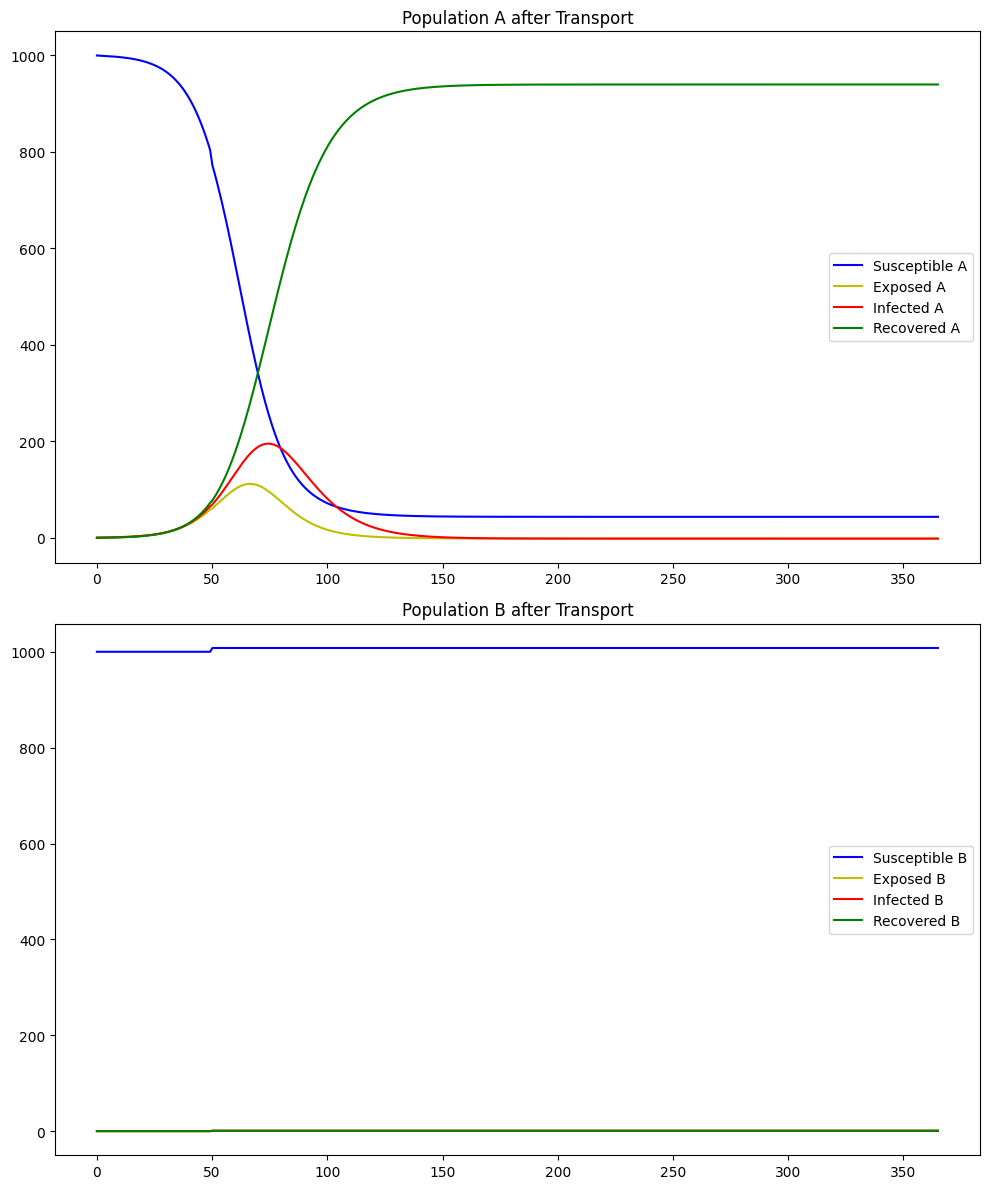

In [6]:
# Testing the TransportBehavior class
model_A = SEIRModel(N=1000, I0=1)
model_B = SEIRModel(N=1000, I0=0)
model_A.integrate(beta=0.3, sigma=1./5., gamma=1./10.)
model_B.integrate(beta=0.3, sigma=1./5., gamma=1./10.)

transport = TransportBehavior(model_A, model_B)
transport.set_transport_rates(rate_S=0.02, rate_E=0.02, rate_I=0.02, rate_R=0.02)
transport.set_stay_rate(0.5)  # 50% of people decide to stay after moving
transport.apply_transport(day=50)

# Plotting results after applying transport behavior
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.plot(model_A.results['t'], model_A.results['S'], 'b', label='Susceptible A')
ax1.plot(model_A.results['t'], model_A.results['E'], 'y', label='Exposed A')
ax1.plot(model_A.results['t'], model_A.results['I'], 'r', label='Infected A')
ax1.plot(model_A.results['t'], model_A.results['R'], 'g', label='Recovered A')
ax1.set_title('Population A after Transport')
ax1.legend()
ax2.plot(model_B.results['t'], model_B.results['S'], 'b', label='Susceptible B')
ax2.plot(model_B.results['t'], model_B.results['E'], 'y', label='Exposed B')
ax2.plot(model_B.results['t'], model_B.results['I'], 'r', label='Infected B')
ax2.plot(model_B.results['t'], model_B.results['R'], 'g', label='Recovered B')
ax2.set_title('Population B after Transport')
ax2.legend()
plt.tight_layout()
plt.show()